MHz per volt 585 -794


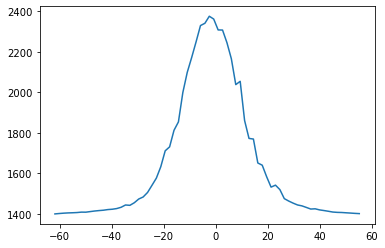

In [1]:
import numpy as np
from MakeMHzScale import  MHzScale
from astropy.io import fits
import matplotlib.pyplot as plt
import scipy.special as  spf
import scipy.optimize as spo
angle=13*np.pi/180
kb=1.38e-23
m=1.16e-26



sigmaLaserJitterMeasured=1.6 #MHz. measured on day of data taking

fitsFile=fits.open('run10Far.fits') #9_23_21
imagesArrRaw=fitsFile[0].data
imagesArrRaw=imagesArrRaw.astype(float) #need to convert to float from int16
imagesArrRaw=np.flip(imagesArrRaw,axis=1)


DAQData=np.loadtxt('run10DAQData.csv',delimiter=',')
MHzArr=MHzScale(DAQData).make_MHZ_Scale(False)
startVolt,stopVolt=-.9,-.7

galvoVoltArr=DAQData[:,0]
P=np.polyfit(galvoVoltArr,MHzArr, 1)
imageVoltArr=np.linspace(startVolt,stopVolt,num=len(imagesArrRaw))
imagesMHzArr=P[1]+P[0]*imageVoltArr

plt.plot(imagesMHzArr,np.mean(np.mean(imagesArrRaw,axis=1),axis=1))
plt.show()

In [2]:
import warnings
import time
def extract_Sub_Image_From_Fits_Coords(images,xFitsCoord,yFitsCoord,xWidth,yWidth,overRideDataTypeWarning=False):
    #images: A list,array or single images from which to extract the subimages
    #xFitsCoord: x coordinate in fits file of box center
    #yFitsCoord: y coordinate in fits file of box center
    #xWidth: x width of box in fits file
    #yWidth: y widht of box in fits file
    if not all(np.issubdtype(type(val),int) for val in [xFitsCoord,yFitsCoord,xWidth,yWidth]): #Have to do an annoying
        # trick to accept numpy and python integers for these values
        raise Exception("coords and dimensions must bet integers")
    if isinstance(images,np.ndarray):
        imageArr=images
    else:
        imageArr=np.array(images)
    if overRideDataTypeWarning==False and imageArr.dtype != 'float64':
        warnings.warn('\n The data type of your image is not a float. \n It is very unlikely this was intentional \n'
                      'This can have serious unintended consequences if you don\'t understand integer behaviour clearly \n '
                      'You can')
        time.sleep(5.0)
    singleImage=False
    if len(imageArr.shape)==2: # if a single image instead of a movie
        singleImage=True
        imageArr=np.array([imageArr]) #convert into a one frame movie
    imageSizeY, imageSizeX=imageArr[0].shape
    if xWidth%2!=1 or yWidth%2!=1:
        raise Exception('Fit file box dimensions must be even for this to work simply')
    if not (xFitsCoord+xWidth//2<imageSizeX and xFitsCoord-xWidth//2>0 ):
        raise Exception("box in x dimension exceeds image bounds")
    if not (yFitsCoord+yWidth//2<imageSizeY and yFitsCoord-yWidth//2>0 ):
        raise Exception("box in y dimension exceeds image bounds")
    xStartFits=xFitsCoord-(xWidth-1)//2
    xEndFits=xFitsCoord+(xWidth-1)//2
    xStartNP=xStartFits-1
    xEndNP=xEndFits

    yStartFits=yFitsCoord-(yWidth-1)//2
    yEndFits=yFitsCoord+(yWidth-1)//2

    yStartNP=(imageSizeY-yEndFits)
    yEndNP=(imageSizeY-yStartFits)+1
    subImages=imageArr[:, yStartNP:yEndNP, xStartNP:xEndNP]
    if singleImage==True:
        subImage=subImages[0]
        return subImage
    else:
        return subImages

In [3]:
background=imagesArrRaw[0]
imagesArr=imagesArrRaw-background

In [4]:
from DataAnalysis import fit_Spectral_Data
import multiprocess as mp


rp=5.0
Lo=88
Lo+=rp/2 #use the center of the lens as the location of the lens
rpMin=4.0
angleMax=rp/Lo
angleMin=(rpMin)/(Lo+5)


sphericalAbLength=10.0 #cm
lensAngle=(angleMin+angleMax)/2
spotSize=.45 #cm. FWHM upper
boxHeight_CM=spotSize+2*(sphericalAbLength/2)*np.tan(lensAngle)
pixelSize_CM=1e2*25e-6*4*3 #convert to cm, pixelsize*binning*magnification
pixelHeight=2*(int(boxHeight_CM/pixelSize_CM)//2)+1 #pixel height in pixels
pixelWidth=5 #reasonable size

subImage=extract_Sub_Image_From_Fits_Coords(imagesArr,110,144,pixelWidth,pixelHeight)
spectralProfile=np.mean(np.mean(subImage,axis=1),axis=1)
spectralProfile=spectralProfile/spectralProfile.max()

def get_T_And_Residuals(angle):
    v0=210.0
    vtMax=v0*np.sin(angle)
    if angle==0.0:
        vtMax=None
    fitSol=fit_Spectral_Data(imagesMHzArr,spectralProfile,peakMode='single',gammaLockedToNatural=True,vTMaxLens=vtMax, laserJitter=sigmaLaserJitterMeasured)
    # params=fitSol.get_Params()
    # xPlot=np.linspace(imagesMHzArr[0],imagesMHzArr[-5],10_001)
    # plt.scatter(imagesMHzArr,spectralProfile)
    # plt.plot(imagesMHzArr,fitSol.fit_Result_Function(imagesMHzArr),c='r')
    # plt.xlabel('Frequency (MHz)')
    # plt.ylabel('Signal (arbitrary)')
    # plt.show()
    # fitSol.print_Results()
    return fitSol.fitResultsDict['temperature'],np.sum(fitSol.fitResiduals**2)/len(imagesMHzArr)
angleArr=np.linspace(.01,.08,200)
angleArr=np.append(0.0,angleArr)
with mp.Pool() as pool:
    results=np.asarray(pool.map(get_T_And_Residuals,angleArr))

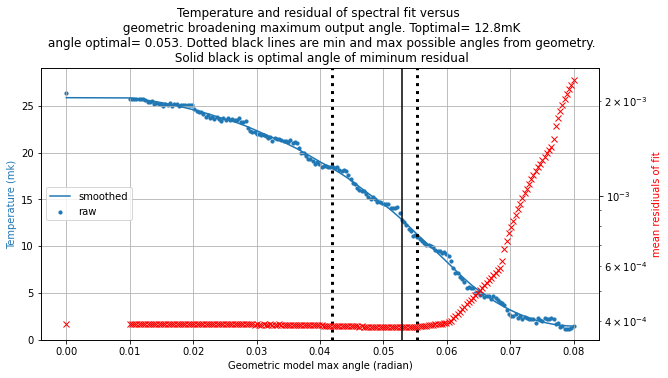

In [5]:
from scipy.signal import savgol_filter
TRough=results[:,0]
TSmooth=savgol_filter(TRough,71,2)



fig,ax1=plt.subplots(figsize=(10,5))
ax1.set_ylabel('Temperature (mk)',c='C0')
ax1.set_xlabel('Geometric model max angle (radian)')
ax1.plot(angleArr,TSmooth,label='smoothed')
ax1.scatter(angleArr,TRough,s=10,label='raw')
ax1.axvline(x=angleMax,c='black',linestyle=':',linewidth=3)
ax1.axvline(x=angleMin,c='black',linestyle=':',linewidth=3)
ax1.set_ylim([0.0,TRough.max()*1.1])
ax1.legend(loc='center left')
ax2=ax1.twinx()
ax2.semilogy(angleArr,results[:,1],c='r',linewidth=0.0,marker='x')
ax2.set_ylabel("mean residiuals of fit",color='r')
angleOptimal=angleArr[np.argmin(results[:,1])]
TOptimal=TSmooth[np.argmin(results[:,1])]
ax2.axvline(x=angleOptimal,c='black')
ax2.tick_params(axis='y')
ax1.grid()
plt.title("Temperature and residual of spectral fit versus \n geometric broadening maximum output angle. Toptimal= "+str(np.round(TOptimal,1))+ 'mK'
          + '\n angle optimal= '+str(np.round(angleOptimal,3))+'. Dotted black lines are min and max possible angles from geometry.'
                                                               '\n Solid black is optimal angle of miminum residual')
plt.show()


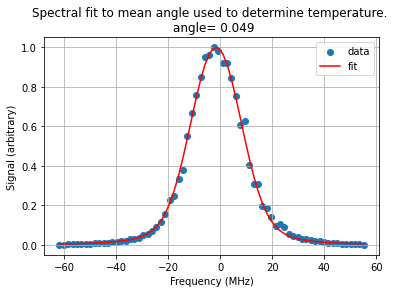

center frequency -2.429084649381487
signal height 0.9984593479230353
vertical offset -0.001444658720016423
sigma, STDev 6.297588511781717
gamma, FWHM 5.860000631934031
laser jitter 1.6
peak mode single
including lens heating True
max transverse lens velocity 10.195001758945542
temperature 15.07478091532927
|----Spectral Fit Solution--------
|Solution Parameters (rounded to 3 sig figs): 
|center frequency: -2.43 MHz
|signal height: 0.998 au
|vertical offset: -0.00144 au
|sigma, STDev: 6.3 MHz
|gamma, FWHM: 5.86 MHz
|laser jitter: 1.6 MHz
|peak mode: single 
|including lens heating: True 
|max transverse lens velocity: 10.2 m/s
|temperature: 15.1 mK
|---------------------------------


/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/sigfig/sigfig.py:572: UserWarning: warning: 3 significant figures requested from number with only 2 significant figures
  warn("warning: %d significant figures requested from number with only %d significant figures" % (given['sigfigs'], len(num.map)))


In [6]:
#show fit of the mean angle
v0=210.0
vtMax=v0*np.sin((angleMax+angleMin)/2)
if angle==0.0:
    vtMax=None
fitSol=fit_Spectral_Data(imagesMHzArr,spectralProfile,peakMode='single',gammaLockedToNatural=True,vTMaxLens=vtMax, laserJitter=sigmaLaserJitterMeasured)
plt.title('Spectral fit to mean angle used to determine temperature. \n angle= '+str(np.round((angleMax+angleMin)/2,3)))
plt.scatter(imagesMHzArr,spectralProfile,label='data')
plt.plot(imagesMHzArr,fitSol.fit_Result_Function(imagesMHzArr),c='r',label='fit')
plt.xlabel("Frequency (MHz)")
plt.ylabel('Signal (arbitrary)')
plt.legend()
plt.grid()
plt.show()
fitSol.print_Results()

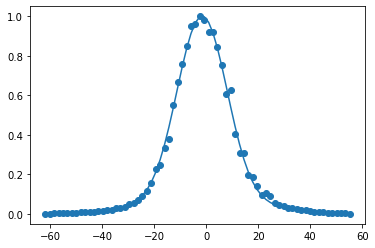

2.42322078641348

In [7]:
# get the error. Have to refit with scipy to get covariance matrix easily!!
def wrapper(x,v0,a,b,sigma):
    gamma=5.86
    params=[v0,a,b,sigma,gamma]
    return fitSol.fit_Function(x,params)
params,pcov=spo.curve_fit(wrapper,imagesMHzArr,spectralProfile)
perr = np.sqrt(np.diag(pcov))
plt.scatter(imagesMHzArr,spectralProfile)
plt.plot(imagesMHzArr,wrapper(imagesMHzArr,*params))
plt.show()
fractionalSigmaError=perr[-1]/params[-1]
fractionalSigmaError*1e2

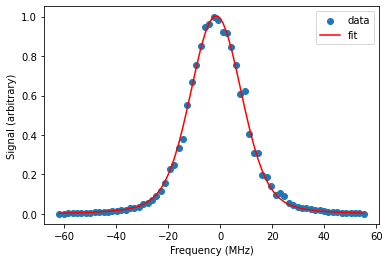

(13.083279028376843, 19.624918542565265)

In [20]:
#find velocity FWHM
fitSol=fit_Spectral_Data(imagesMHzArr,spectralProfile,peakMode='single',gammaLockedToNatural=True,vTMaxLens=None, laserJitter=sigmaLaserJitterMeasured)
# plt.title('Fit with no geometric model to extract velocity spread.\n FWHM in velocity is 13.08 m/s')
plt.scatter(imagesMHzArr,spectralProfile,label='data')
plt.plot(imagesMHzArr,fitSol.fit_Result_Function(imagesMHzArr),c='r',label='fit')
plt.xlabel("Frequency (MHz)")
plt.ylabel('Signal (arbitrary)')
FWHM=fitSol.fitResultsDict['sigma, STDev']*2.355
f0=fitSol.fitResultsDict['center frequency']
# plt.plot([f0-FWHM/2,f0+FWHM/2],[.5,.5],label="FHWM")
# plt.axvline(x=f0-FWHM/2)
# plt.axvline(x=f0+FWHM/2)
plt.legend()
# plt.grid()
plt.savefig('poop1',dpi=100,format='pdf')
plt.show()
FWHM_Velocity=FWHM/1.5
FWHM_Velocity,FWHM

### plot individual profiles

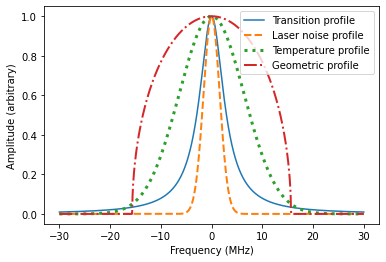

In [21]:
# profile
def laser_Gauss(x):
    return 1*np.exp(-.5*(x/sigmaLaserJitterMeasured)**2)
def temp_Gauss(x,sigma):
    return np.exp(-.5*(x/sigma)**2)
def transition_Prof(x):
    #f, frequency value
    #a, height of voigt
    #f0, center frequency
    #gamma, FWHM of the lorentzian
    gammaFWHM=5.86
    gammaHWHM=gammaFWHM/2.0
    v0=spf.voigt_profile(0,1e-12,gammaHWHM)
    v=spf.voigt_profile(x,1e-12,gammaHWHM)/v0
    return 1*v
@np.vectorize
def geoemtric_Profile(x,vMax):
    xMax=vMax*1e-6/671e-9
    if np.abs(x)>xMax:
        return 0.0
    else:
        return 1*np.sqrt(1-(x/xMax)**2)
vMax=10.5
sigmaTemp=6.4
freqArr=np.linspace(-30,30,1000)
plt.plot(freqArr,transition_Prof(freqArr),label='Transition profile')
plt.plot(freqArr,laser_Gauss(freqArr),linestyle='--',linewidth=2,label='Laser noise profile')
plt.plot(freqArr,temp_Gauss(freqArr,sigmaTemp),linestyle=':',linewidth=3,label='Temperature profile')
plt.plot(freqArr,geoemtric_Profile(freqArr,vMax),linestyle='-.',linewidth=2,label='Geometric profile')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Amplitude (arbitrary)')
plt.legend()
plt.savefig('poop2',dpi=100,format='pdf')
plt.show()

In [46]:
r=np.linspace(0,1.0)
np.mean(r)
np.sum(r**2)/50,np.mean(r)**2

(0.336734693877551, 0.25)

In [33]:
x=np.random.    
y=np.linspace(0.0,1.0,100)
bins=np.linspace(0.0,1.0,10)
np.digitize(x,bins)

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10])